#### Prepared for Gabor's Data Analysis

# Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

# Chapter 17

Data preparation

In [41]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *

warnings.filterwarnings("ignore")


In [42]:
# Current script folder
path = os.getcwd()
path

'/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_2'

In [43]:
# Import the prewritten helper functions
#from py_helper_functions import *


# Import data

In [44]:
# csv_path = os.path.join(data_in, "cs_bisnode_panel.csv")

# data = pd.read_csv(csv_path)
data = pd.read_csv("https://osf.io/download/3qyut/")


In [45]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)
data = data.query("year !=2016")



# Label engineering


In [46]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN


In [47]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)


In [48]:
data = data[data['year'].isin([2012, 2013])]


In [49]:
data.year.value_counts()

year
2012    46412
2013    46412
Name: count, dtype: int64

only 10% of firms defaulted
avg sales are half a million but wiht high sd of 3 million, min sales is negative? the top 75% earn more than 100k, we have a veryyy long right tail 
on avg 70 % of the firms are new, the sd suggests an even dist 

In [50]:
data["default"].describe()


count    92824.000000
mean         0.100750
std          0.300999
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

In [51]:
data["sales"].describe()


count    5.546900e+04
mean     4.532184e+05
std      3.709542e+06
min     -6.072593e+04
25%      2.666667e+03
50%      2.494445e+04
75%      9.929630e+04
max      1.099510e+08
Name: sales, dtype: float64

In [52]:

# Replace negative sales values with 1
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)


In [53]:
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)


In [54]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)


In [55]:
data["new"].describe()


count    92824.000000
mean         0.776340
std          0.416699
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: new, dtype: float64

# Sample design

In [56]:
# look at cross section
data = data.query("year==2012 or year ==2013 & status_alive == 1")
# look at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")


In [57]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,exit_date,labor_avg,status_alive,default,ln_sales,sales_mil,sales_mil_log,d1_sales_mil_log,age,new
324885,2012,1.001541e+06,2012-01-01,2012-12-31,481.481476,9.629630e+03,1.303704e+03,0.0,0.000000,0.000000,...,NaN,NaN,1,0,7.093159,0.001204,-6.722352,0.000000,4.0,1.0
324886,2012,1.002029e+06,2012-01-01,2012-12-31,14929.629883,2.038852e+05,1.204445e+05,0.0,0.000000,0.000000,...,NaN,0.458333,1,0,13.943477,1.136515,0.127966,0.000000,6.0,1.0
324887,2012,1.003200e+06,2012-01-01,2012-12-31,25.925926,2.222222e+01,1.099630e+04,0.0,0.000000,0.000000,...,2014-08-09,NaN,1,1,7.932070,0.002785,-5.883441,0.000000,9.0,1.0
324891,2012,1.011889e+06,2012-01-01,2012-12-31,36625.925781,1.601667e+05,1.891111e+04,0.0,0.000000,0.000000,...,NaN,1.621212,1,0,12.980031,0.433667,-0.835479,0.000000,20.0,1.0
324892,2012,1.014183e+06,2012-01-01,2012-12-31,12551.851562,1.999037e+05,8.274074e+03,0.0,7.407407,7.407407,...,NaN,0.715278,1,0,11.773208,0.129730,-2.042303,0.000000,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417697,2013,4.638854e+11,2013-01-01,2013-12-31,4977.777832,6.201111e+04,3.924074e+04,0.0,0.000000,0.000000,...,NaN,0.083333,1,0,12.819485,0.369344,-0.996026,0.860924,4.0,0.0
417700,2013,4.639820e+11,2013-01-01,2013-12-31,12003.704102,1.091148e+05,1.506185e+05,0.0,0.000000,0.000000,...,NaN,0.506944,1,0,12.821779,0.370193,-0.993732,0.662642,18.0,0.0
417702,2013,4.640212e+11,2013-01-01,2013-12-31,2603.703613,4.088148e+04,3.361111e+04,0.0,0.000000,0.000000,...,NaN,0.083333,1,0,10.973738,0.058322,-2.841772,0.000000,NaN,1.0
417703,2013,4.640446e+11,2013-01-01,2013-12-31,77248.148438,6.055000e+06,1.930922e+06,0.0,0.000000,0.000000,...,NaN,1.993056,1,0,15.971726,8.638381,2.156215,0.012160,5.0,0.0


In [58]:
data["default"].describe()


count    43187.000000
mean         0.194735
std          0.396001
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

In [59]:

data.to_csv(path + "/firm_exit.csv", index=False)


# Feature engineering

In [60]:
current_csv_path = os.path.join(path, "firm_exit.csv")
data = pd.read_csv(current_csv_path)


In [61]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])


In [62]:
data.groupby("ind2_cat").count()["comp_id"]

ind2_cat
20.0      105
26.0     2130
27.0     1296
28.0     3897
29.0      566
30.0      340
32.0      281
33.0     3894
40.0      427
55.0     4581
56.0    25167
60.0      493
99.0       10
Name: comp_id, dtype: int64

In [63]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


In [64]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]


flag_asset_problem
0.0    43149
1.0       27
Name: comp_id, dtype: int64

In [65]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In [66]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()


count    4.317600e+04
mean     2.606682e+05
std      1.536095e+06
min      0.000000e+00
25%      6.813889e+03
50%      2.495926e+04
75%      9.864352e+04
max      1.325147e+08
Name: total_assets_bs, dtype: float64

In [67]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


In [68]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)


In [69]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [70]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [71]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [72]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


In [73]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [74]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)


In [75]:
data["labor_avg"].describe()


count    35343.000000
mean         0.639393
std          1.620090
min          0.083333
25%          0.106061
50%          0.238095
75%          0.534722
max         63.974998
Name: labor_avg, dtype: float64

In [76]:
data["labor_avg_mod"].describe()


count    43187.000000
mean         0.639393
std          1.465593
min          0.083333
25%          0.143939
50%          0.333333
75%          0.639393
max         63.974998
Name: labor_avg_mod, dtype: float64

In [77]:
data = data.drop(["labor_avg"], axis=1)


In [78]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])


In [79]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


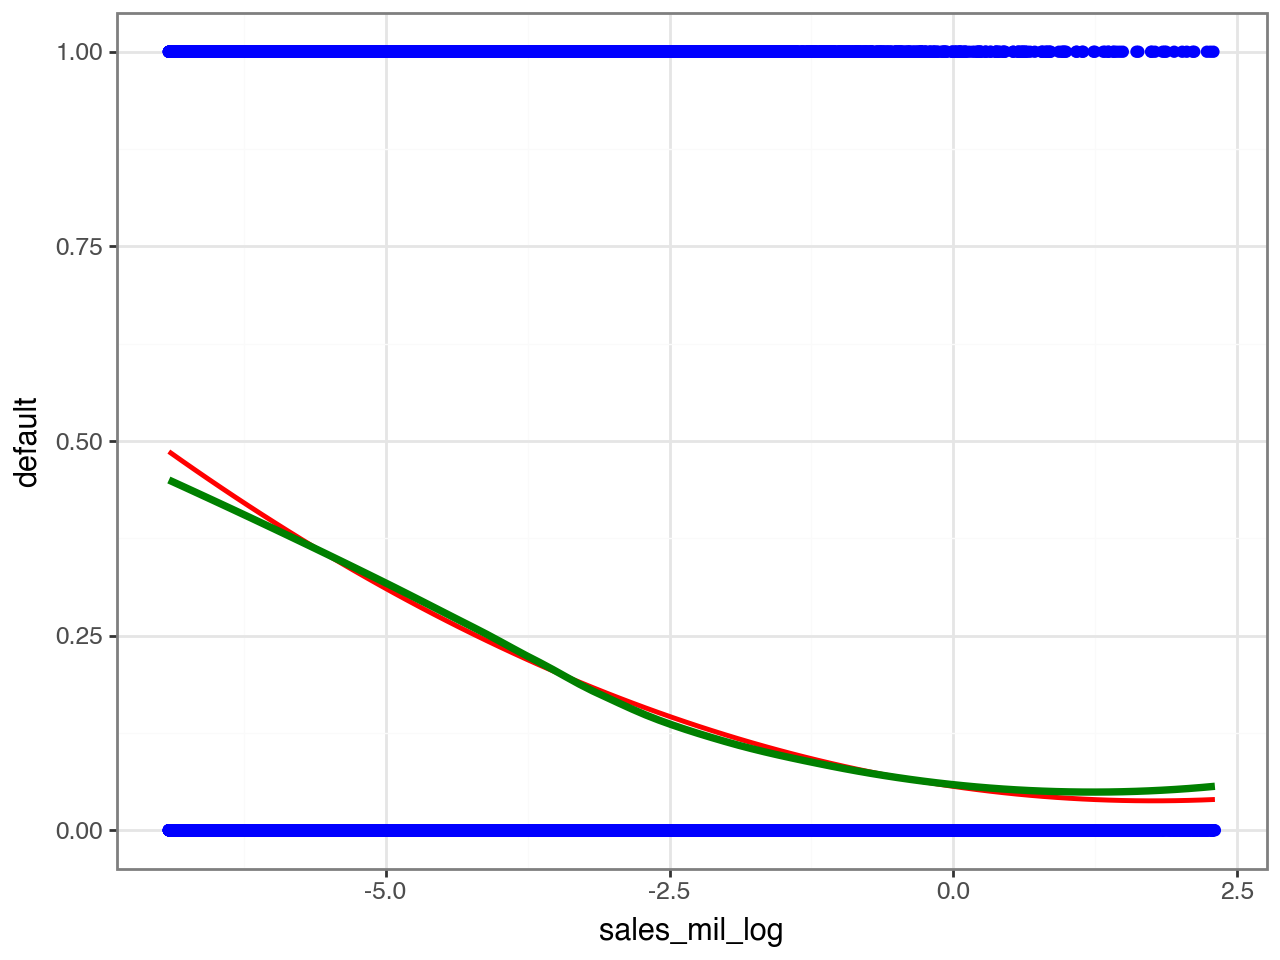

In [80]:
color = ['blue', 'red', 'green']

(
    ggplot(data, aes(x="sales_mil_log", y="default"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="default")
    + theme_bw()
)


In [81]:
# Linear regressions
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())


                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     1381.
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:10:51   Log-Likelihood:                -19935.
No. Observations:               43187   AIC:                         3.988e+04
Df Residuals:                   43184   BIC:                         3.990e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0563      0.004  

In [82]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()


count    43187.000000
mean        -0.023588
std          0.662097
min         -6.907755
25%          0.000000
50%          0.000000
75%          0.000000
max          9.344612
Name: d1_sales_mil_log, dtype: float64

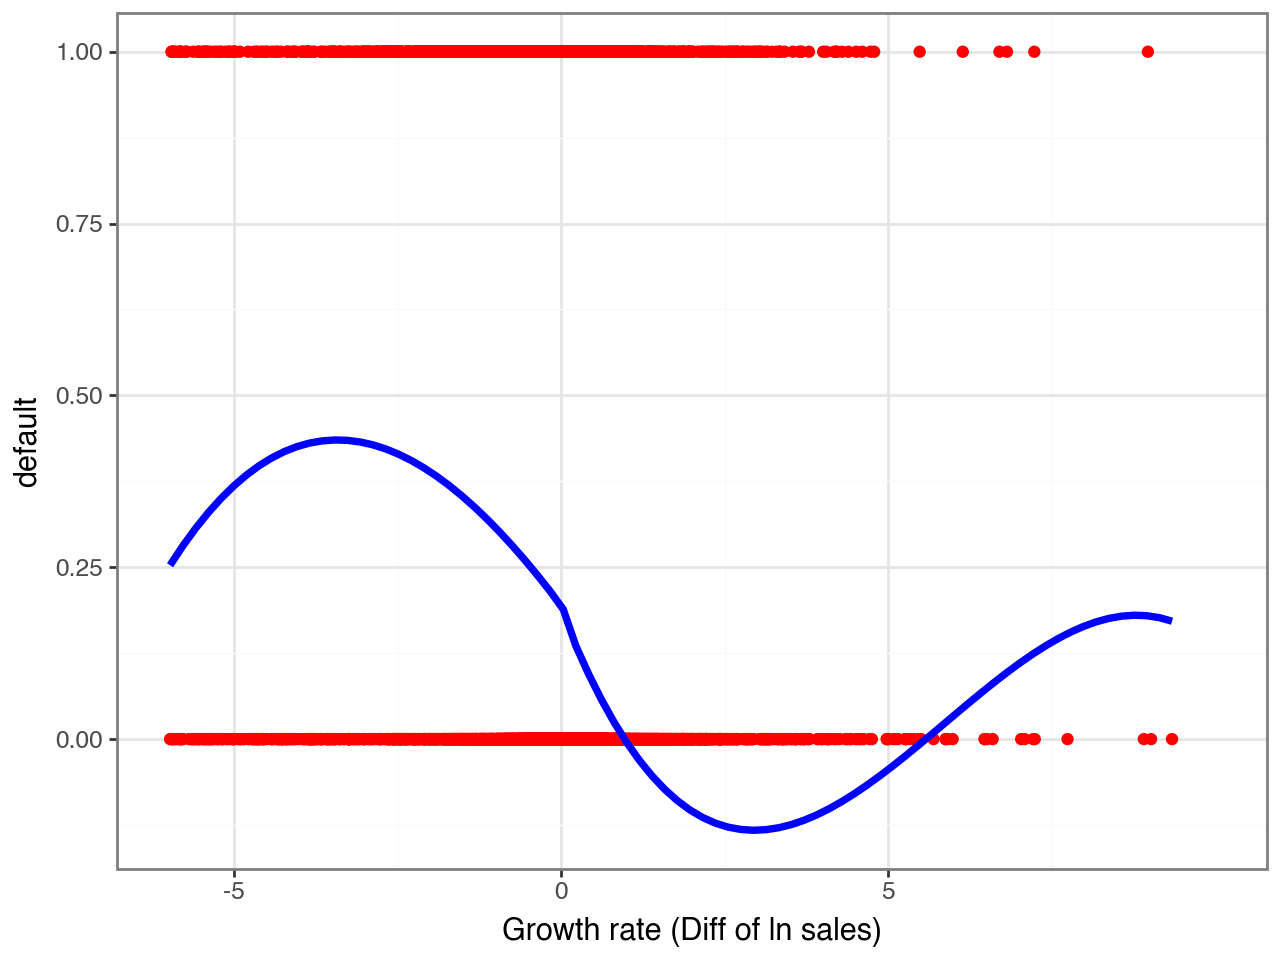

In [83]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-6, 10), breaks=np.arange(-5, 10, 5))
    + theme_bw()
)


In [84]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2


In [85]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])


In [86]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    37919.000000
mean         8.872966
std          7.030835
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         62.000000
Name: age, dtype: float64

In [88]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()


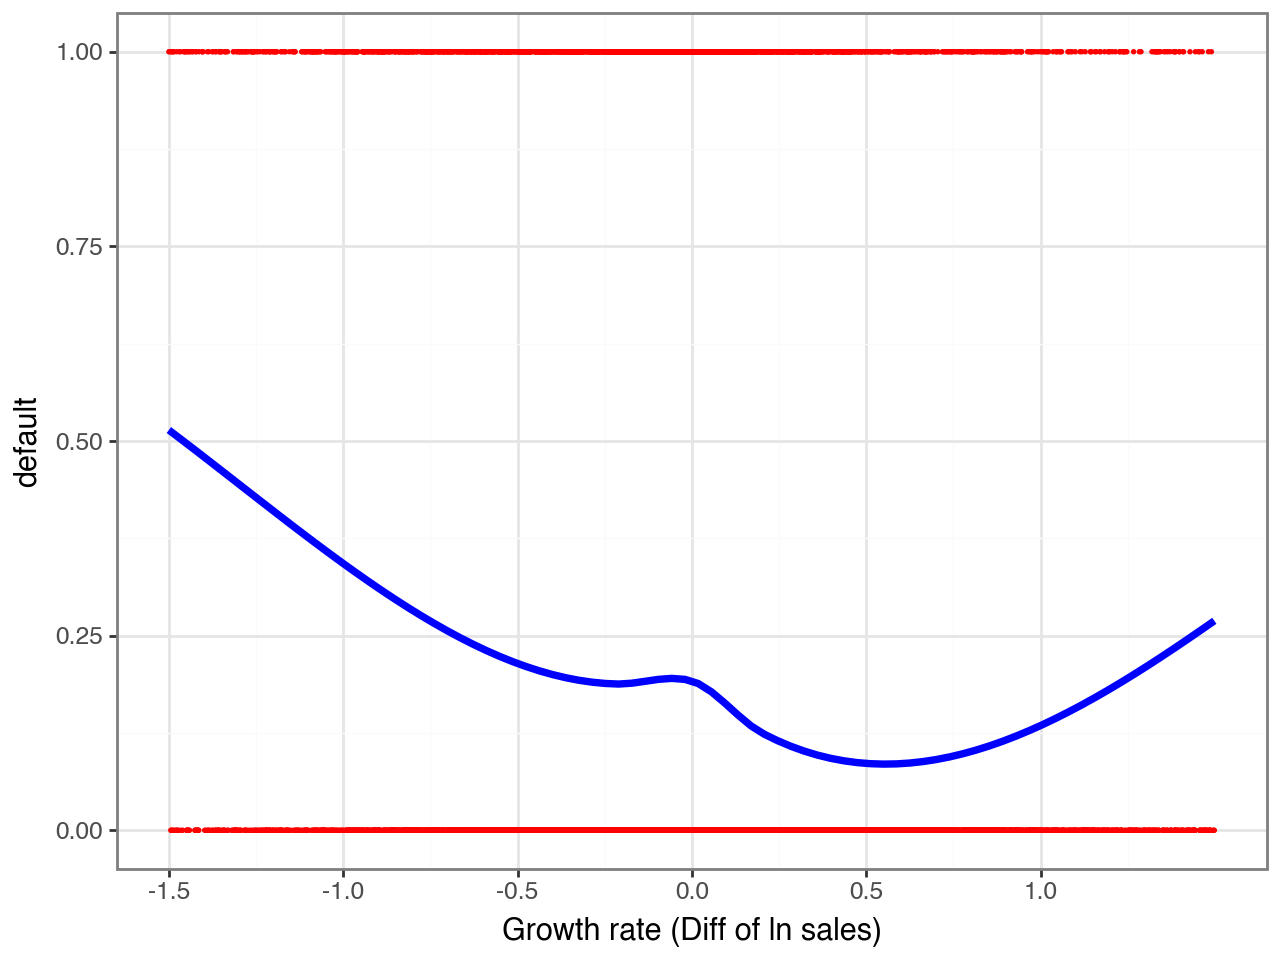

In [89]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=np.arange(-1.5, 1.5, 0.5))
    + theme_bw()
)


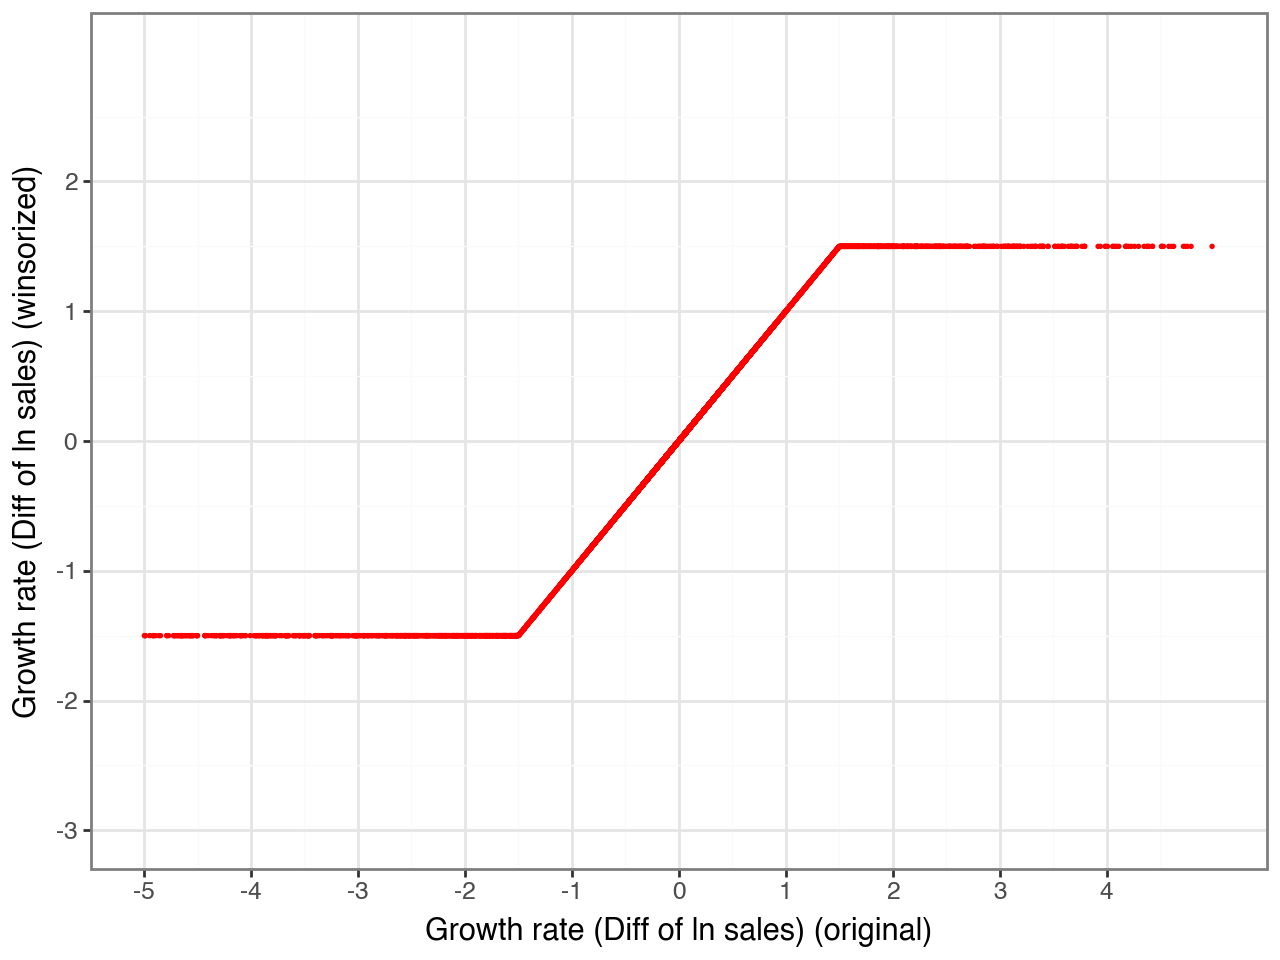

In [90]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=np.arange(-5, 5, 1))
    + scale_y_continuous(limits=(-3, 3), breaks=np.arange(-3, 3, 1))
    + theme_bw()
)


creating the target variable: 

I chose the 20% growth threshold because it aligns with the OECD definition of high-growth firms, ensuring comparability with established economic research. We opted to measure growth over one year instead of two to capture more recent expansion trends and maintain a larger sample size, avoiding potential firm exits or structural changes over longer periods. The winsorized version of sales growth (d1_sales_mil_log_mod) was used to minimize the impact of extreme outliers, which could distort the classification of fast-growing firms. Finally, we worked with log-transformed sales because it stabilizes variance, handles skewed distributions, and allows us to interpret growth rates in a more linear and economically meaningful way.

we discovered that 21% of the firms in our sample are considered "fast growers" - we also discovered a relationship between rapid firm expansion and increased likelihood of default. 


In [91]:
import numpy as np

# Define the fast growth threshold (20% growth in log terms)
growth_threshold = np.log(1.2)  # ≈ 0.182

# Create the target variable using the winsorized log sales growth
data["fast_growth"] = (data["d1_sales_mil_log_mod"] > growth_threshold).astype(int)

# Check distribution
print(data["fast_growth"].value_counts(normalize=True))

fast_growth
0    0.873441
1    0.126559
Name: proportion, dtype: float64


In [92]:
data.to_csv(path + "/firms_clean.csv", index=False)
